In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt

import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

import h5py
import cartopy.crs as ccrs
    
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

SNAPSHOTS_DIR = "data/"

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


This notebook presents a real-data test of a 12-level sigma model: Gill pattern in the tropics with prescribed DJF basic-state wind, temperature, surface pressure, and sigma velocity. The prescribed heating is as in Ting&Yu, 1998 (eqn. 2,3,4).

The results are not yet perfect (I am not using the same vertical levels or basic state, and not sure the model has reached a steady state yet) but look quite similar to Ting&Yu, 1998.

# Getting the ERA5 basic state (DJF 2020)

This next cell requires functions and data that are not present in this folder.
Please adapt to your local setup.

In [ ]:
# import os; import sys
# p = os.path.abspath('/global/homes/q/qnicolas/')
# if p not in sys.path:
#     sys.path.append(p)
# from tools.e5tools import e5_monthly_file

# def get_djfmean(varcode):
#     return xr.open_dataset(e5_monthly_file(varcode,2020)).groupby("time.season").mean("time").sel(season='DJF').mean('longitude')

# # %%time
# u_djf = get_djfmean('128_131_u').U
# v_djf = get_djfmean('128_132_v').V
# t_djf = get_djfmean('128_130_t').T
# omega_djf = get_djfmean('128_135_w').W
# ps_djf = get_djfmean('128_134_sp').SP
# xr.merge([u_djf,v_djf,t_djf,omega_djf,ps_djf]).to_netcdf("era5_basicstate.nc")


# Analysis

In [2]:
snapshot_id = 'stationarywave_12level_T32_realgill'
gill = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR) #Here, I used one restart, so I need to specifiy the two parts of the output ('s1','s2')
gill = concat_levels(gill ,12)
gill

<xarray.Dataset> Size: 867MB
Dimensions:       (t: 481, longitude: 64, latitude: 32, sigma: 12, : 2,
                   sigma_stag: 11)
Coordinates: (12/13)
    phi           (longitude) float64 512B 0.0 0.09817 0.1963 ... 6.087 6.185
    theta         (latitude) float64 256B 3.068 2.972 2.875 ... 0.1698 0.07399
  * t             (t) float64 4kB 0.0 1.0 2.0 3.0 ... 477.0 478.0 479.0 480.0
    sim_time      (t) float64 4kB 0.0 1.0 2.0 3.0 ... 477.0 478.0 479.0 480.0
    wall_time     (t) float64 4kB 96.35 102.0 102.5 102.9 ... 280.5 280.8 281.2
    timestep      (t) float64 4kB 0.1111 0.1111 0.1111 ... 0.1111 0.1111 0.1111
    ...            ...
    write_number  (t) int64 4kB 1 2 3 4 5 6 7 8 ... 475 476 477 478 479 480 481
  * longitude     (longitude) float64 512B -180.0 -174.4 -168.7 ... 168.7 174.4
  * latitude      (latitude) float64 256B -85.76 -80.27 -74.74 ... 80.27 85.76
    day           (t) float64 4kB 0.0 0.04167 0.08333 0.125 ... 19.92 19.96 20.0
  * sigma         (sigma) float64 96B 0.04167 0.125 0.2083 ... 0.875 0.9583
  * sigma_stag    (sigma_stag) float64 88B 0.08333 0.1667 0.25 ... 0.8333 0.9167
Dimensions without coordinates: 
Data variables:
    Phisfc        (t, longitude, latitude) float64 8MB 0.0 0.0 0.0 ... 0.0 0.0
    lnps          (t, longitude, latitude) float64 8MB 0.0 0.0 ... 6.244e-05
    lnpsbar       (t, longitude, latitude) float64 8MB -0.3257 -0.2317 ... nan
    T             (t, longitude, latitude, sigma) float64 95MB 0.0 ... -0.001456
    Tbar          (t, longitude, latitude, sigma) float64 95MB 236.5 ... nan
    sigmadot      (t, longitude, latitude, sigma) float64 95MB 0.0 0.0 ... 0.0
    u             (t, , longitude, latitude, sigma) float64 189MB 0.0 ... 0.011
    ubar          (t, , longitude, latitude, sigma) float64 189MB 1.908 ... nan
    zeta          (t, longitude, latitude, sigma) float64 95MB 0.0 ... -2.635...
    sigmadotbar   (t, longitude, latitude, sigma_stag) float64 87MB -1.338e-0...

In [3]:
gill_mean = gill.isel(t=slice(400,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

## Basic state

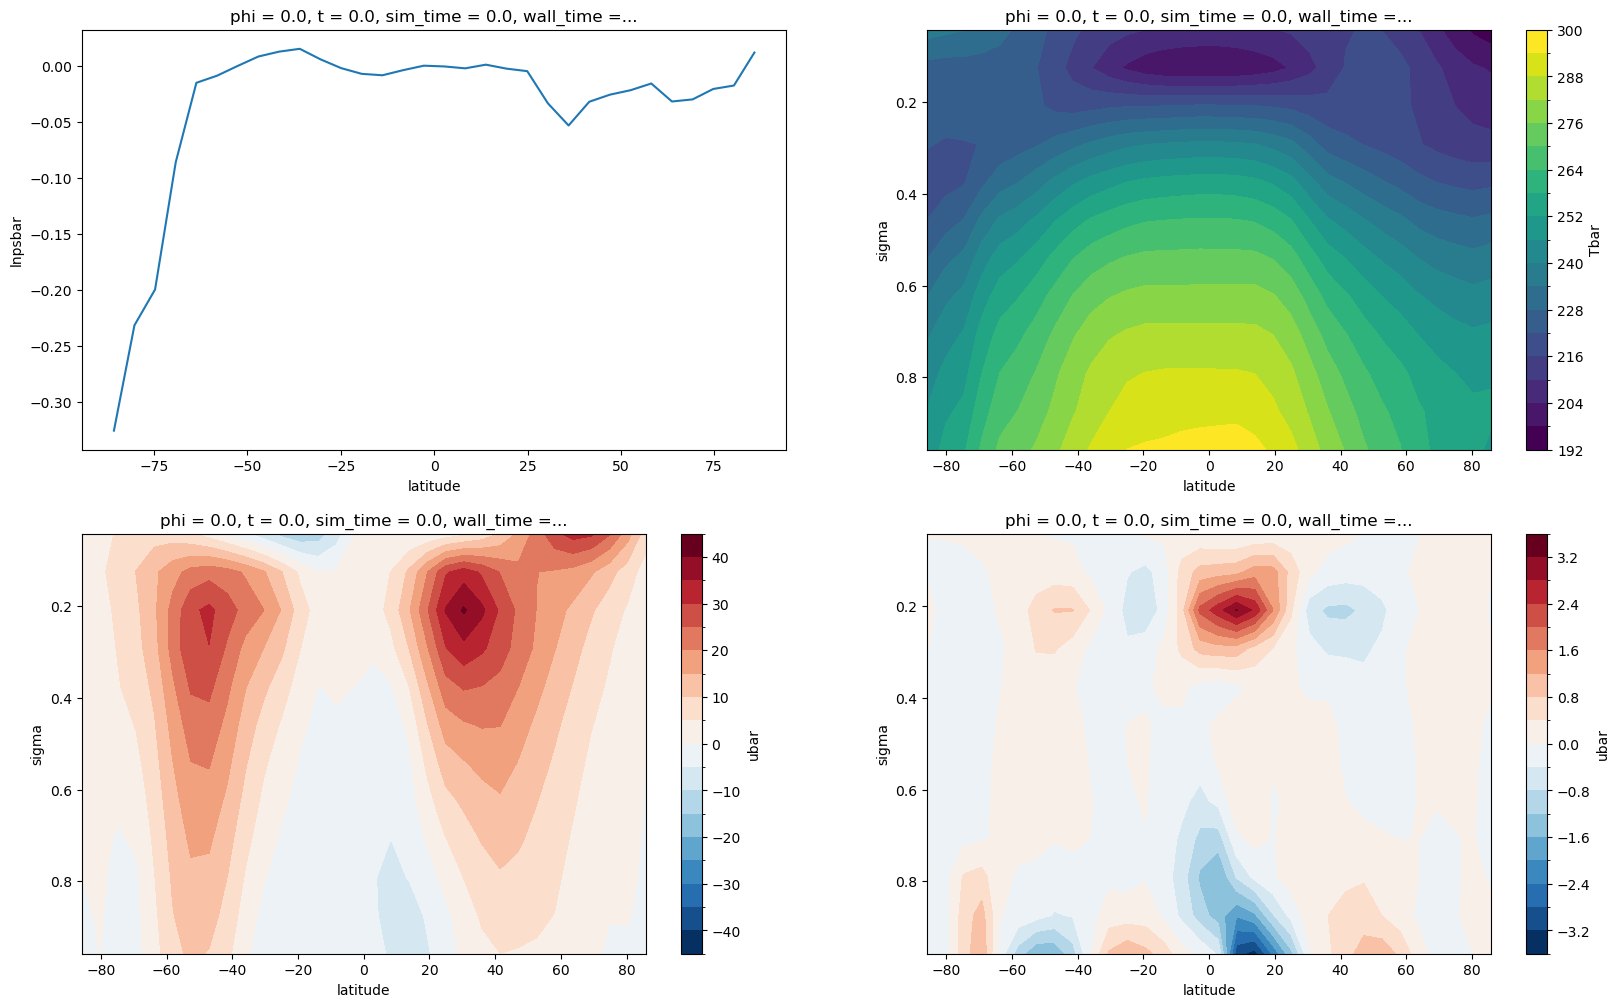

In [4]:
# basic state
_,axs = plt.subplots(2,2,figsize=(20,12)); axs=axs.reshape(-1)
gill_init = gill.isel(t=0,longitude=0)
for i,(ax,var) in enumerate(zip(axs,(gill_init.lnpsbar,gill_init.Tbar,gill_init.ubar[0],-gill_init.ubar[1]))):
    if i==0:
        var.plot(ax=ax)
    else:
        var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)

## Response

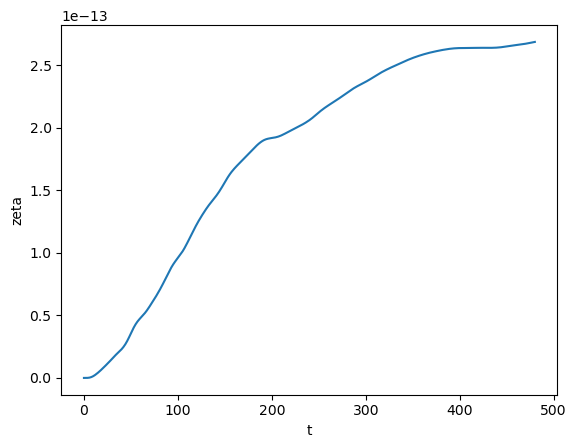

In [5]:
# CONVERGENCE
(gill.zeta**2).mean(('longitude','latitude','sigma')).plot()
#plt.yscale('log')

Text(0.5, 1.0, 'Perturbation vorticity at sigma=0.25 (s^-1)')

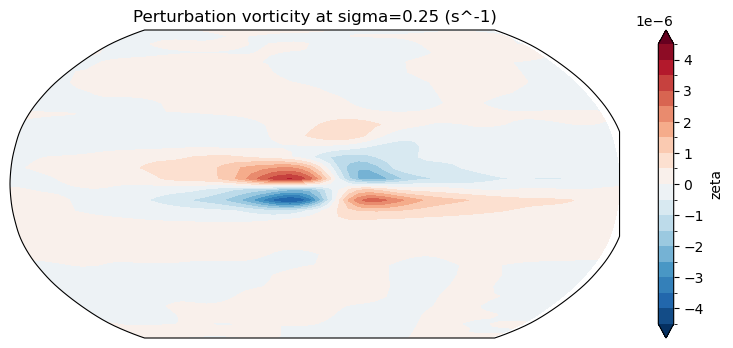

In [7]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.zeta.sel(sigma=0.75,method='nearest')).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
#plot_heating(ax)
plt.title('Perturbation vorticity at sigma=0.25 (s^-1)')

In [8]:
helm = calc_helmholtz(gill_mean.u)

2025-06-24 09:06:16,665 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+02/s
2025-06-24 09:06:16,671 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+02/s
2025-06-24 09:06:16,677 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+02/s
2025-06-24 09:06:16,685 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+02/s
2025-06-24 09:06:16,692 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+02/s
2025-06-24 09:06:16,699 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+02/s
2025-06-24 09:06:16,706 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+02/s
2025-06-24 09:06:16,712 subsystems 0/1 INFO :: Building subproblem matric

In [9]:
def add_wind(ax,u,v,scale=None,key=True,ref=1,unit='m/s',keypos=(0.93,0.95),nm=1):
    """Adds a quiver plot to a matplotlib axis"""
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=nm;m=nm
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=scale,transform=ccrs.PlateCarree())
    if key:
        ax.quiverkey(Q, *keypos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k')


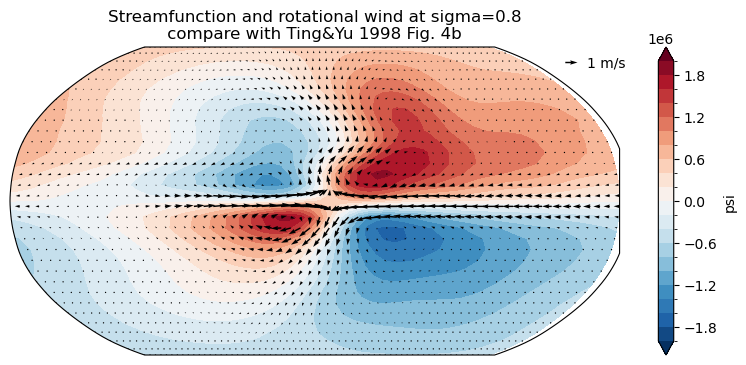

In [10]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
sig=0.8
helm.psi.sel(sigma=sig,method='nearest').plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

u= (helm.u_rot[0].sel(sigma=sig,method='nearest'))
v=-(helm.u_rot[1].sel(sigma=sig,method='nearest'))
add_wind(ax,u,v,scale=50)
plt.title('Streamfunction and rotational wind at sigma=%.1f\n compare with Ting&Yu 1998 Fig. 4b '%sig);

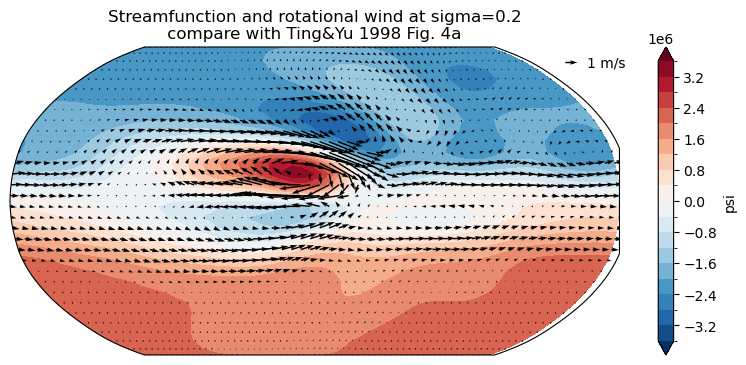

In [11]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
sig=0.25
helm.psi.sel(sigma=sig,method='nearest').plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

u= (helm.u_rot[0].sel(sigma=sig,method='nearest'))
v=-(helm.u_rot[1].sel(sigma=sig,method='nearest'))
add_wind(ax,u,v,scale=50)

plt.title('Streamfunction and rotational wind at sigma=%.1f\n compare with Ting&Yu 1998 Fig. 4a '%sig);

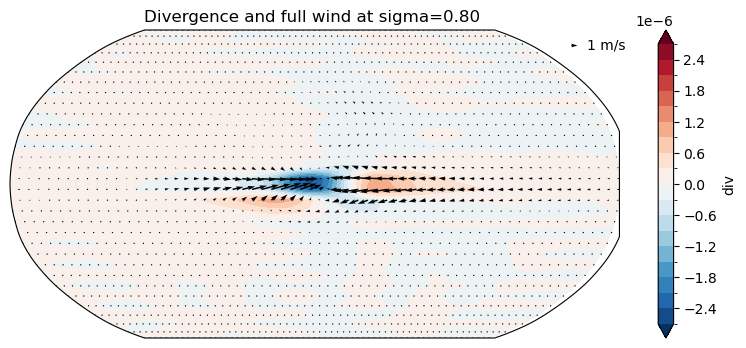

In [12]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})

sig=0.8
helm.div.sel(sigma=sig,method='nearest').plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

u= (gill_mean.u[0].sel(sigma=sig,method='nearest'))
v=-(gill_mean.u[1].sel(sigma=sig,method='nearest'))
add_wind(ax,u,v,scale=100)

plt.title('Divergence and full wind at sigma=%.2f '%sig);